In [52]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from score_recognition import get_digit_frames, crop_score
import random

import imageio

path_images = r'D:\Wormax\data\nn\1_every_5_image'
path_scores = r'D:\Wormax\data\nn\1_every_5'


def generator_helper():
    while True:
        for img_path, score_path in sorted(zip(os.listdir(path_images), os.listdir(path_scores)))[::-1]:
            yield imageio.imread(os.path.join(path_images, img_path)), \
                  imageio.imread(os.path.join(path_scores, score_path))

skip_dinamics = []
def generator(batch_size=1024*4, buffer_size=1024*4):
    prev_sum = 0
    gen = generator_helper()
    buffer = []
    death_timer = 0
    skipped = 0
    while True:
        while len(buffer) < buffer_size:
            frame, score_img = next(gen)
            score_img = score_img / 255
            digit_frames = get_digit_frames(score_img)

            # Death detected as still frames or too dimm image of last digit
            if np.abs(frame[:20].sum().astype(np.int32) - prev_sum) == 0 or digit_frames[5].mean() < 0.15:
                # 130 frames - death
                death_timer = 100
            death_timer = max(0, death_timer - 1)
            prev_sum = frame[:20].sum()
            
            skip_dinamics.append(death_timer)

            if death_timer > 0:
                continue

            # First 2 digits are always blank, last 2 always exist
            arr = [[digit_frames[0], 0], [digit_frames[1], 0], [digit_frames[4], 1], [digit_frames[5], 1]]
            buffer += arr
#         random.shuffle(buffer)
        x, y = zip(*buffer[:batch_size])
        yield np.array(x), np.array(y)
        buffer = buffer[batch_size:]
        
gen = generator()

In [53]:
x, y = next(gen)

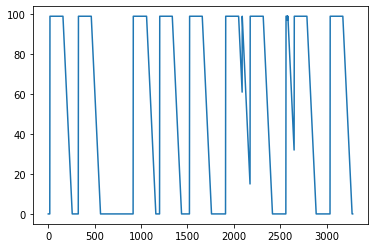

In [54]:
plt.plot(np.arange(len(skip_dinamics)), skip_dinamics)

In [55]:
y

array([0, 0, 1, ..., 0, 1, 1])

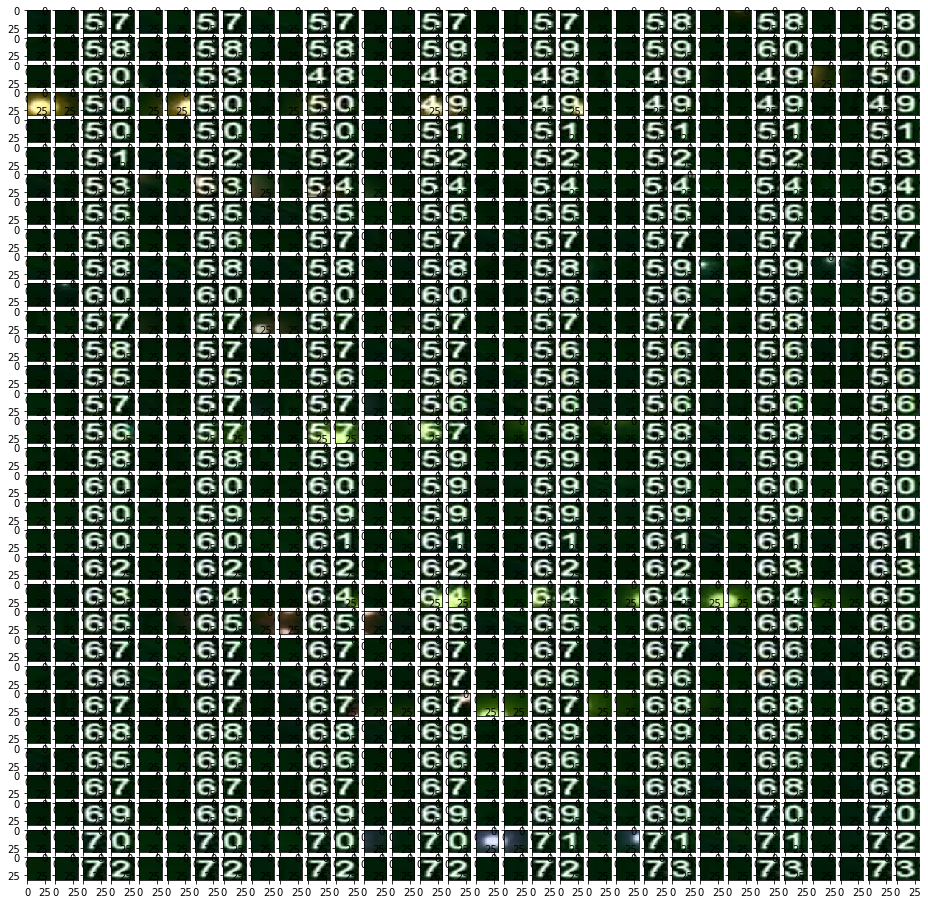

In [56]:
plt.figure(figsize=(16, 16))
for i in range(1024):
    plt.subplot(32, 32,i + 1)
    plt.imshow(x[i])

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

gen = generator(1024*8, 1024*8)

x_train, y_train = next(gen)
print('half way')
x_test, y_test = next(gen)
x_train = x_train.reshape(-1, 32*32*3)
x_test = x_test.reshape(-1, 32*32*3)
print('start training')

# clf = LinearSVC(random_state=0, tol=1e-5).fit(x_train, y_train)

clf = LogisticRegression().fit(x_train, y_train)
# from sklearn.svm import SVC
# clf = SVC(gamma='auto').fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))

half way


C:\Users\lmura\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


start training
0.9993896484375
0.9970703125


In [75]:
0.9962158203125

0.9962158203125

1 0


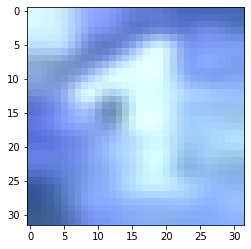

1 0


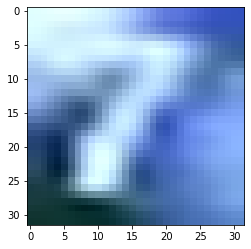

1 0


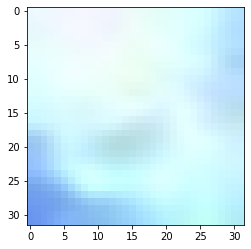

1 0


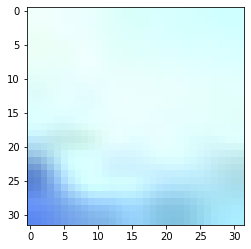

1 0


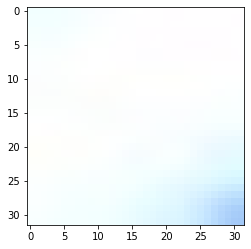

1 0


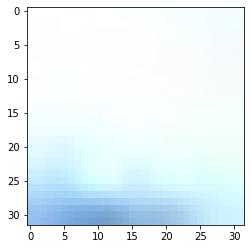

1 0


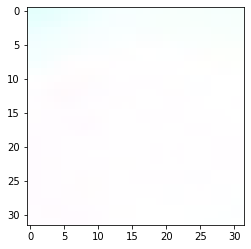

1 0


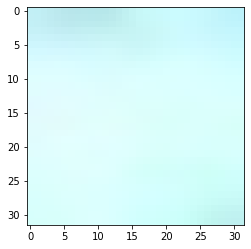

1 0


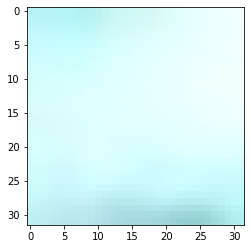

1 0


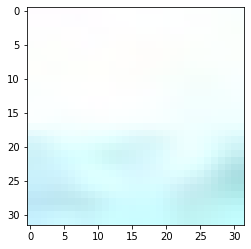

1 0


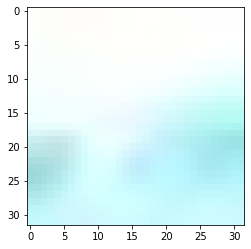

1 0


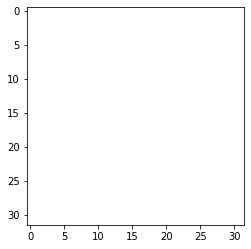

1 0


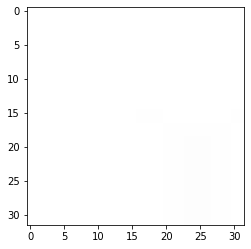

1 0


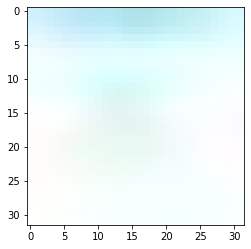

1 0


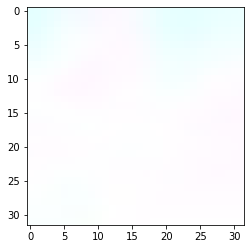

1 0


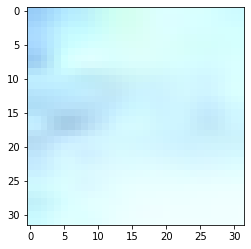

1 0


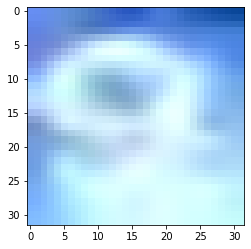

1 0


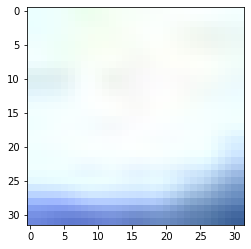

1 0


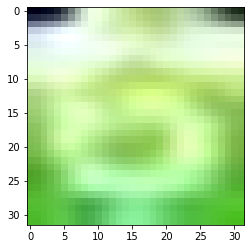

1 0


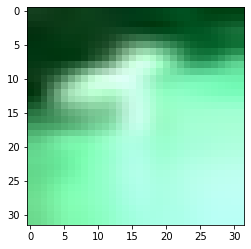

1 0


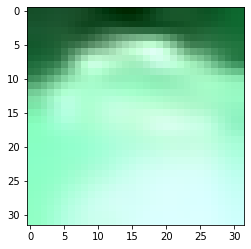

1 0


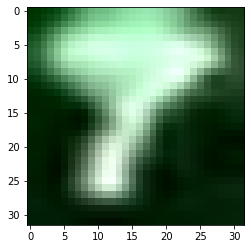

1 0


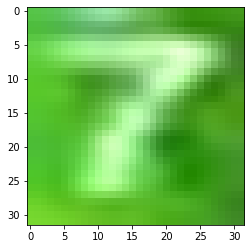

1 0


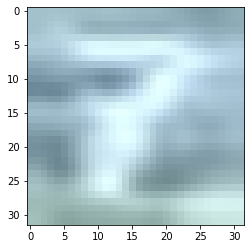

In [78]:
ans = clf.predict(x_test)
for i in range(len(x_test[ans != y_test])):
    plt.figure()
    print(y_test[ans != y_test][i], ans[ans != y_test][i])
    plt.imshow(x_test[ans != y_test][i].reshape(32,32,3))
    plt.show()

In [51]:
len(skip_dinamics)

72901

In [79]:
from joblib import dump, load
dump(clf, 'empty_digit_classifier.joblib') 

['empty_digit_classifier.joblib']